In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.061 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

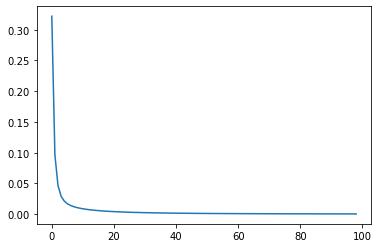

In [8]:
plt.plot(S)

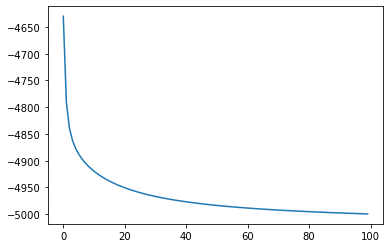

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.00037507858488424975

In [11]:
eta

array([-4629.94739452, -4790.91388538, -4839.09836925, -4862.24570322,
       -4876.82399988, -4887.51065413, -4896.02799898, -4903.15566151,
       -4909.30512881, -4914.71960152, -4919.55558025, -4923.92057998,
       -4927.89234122, -4931.52940361, -4934.87730488, -4937.97241146,
       -4940.84439369, -4943.51788763, -4946.01364881, -4948.34937679,
       -4950.54031994, -4952.5997293 , -4954.5392059 , -4956.36897157,
       -4958.09808339, -4959.7346059 , -4961.28575114, -4962.75799394,
       -4964.15716756, -4965.48854395, -4966.75690153, -4967.9665829 ,
       -4969.12154417, -4970.2253976 , -4971.28144843, -4972.29272695,
       -4973.26201653, -4974.19187823, -4975.08467246, -4975.94257812,
       -4976.76760957, -4977.56163171, -4978.32637346, -4979.06343973,
       -4979.77432221, -4980.46040903, -4981.12299348, -4981.76328179,
       -4982.38240027, -4982.98140168, -4983.56127103, -4984.12293086,
       -4984.66724604, -4985.19502811, -4985.70703926, -4986.20399596,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([3.69452606e+02, 2.08486115e+02, 1.60301631e+02, 1.37154297e+02,
       1.22576001e+02, 1.11889346e+02, 1.03372002e+02, 9.62443390e+01,
       9.00948717e+01, 8.46803990e+01, 7.98444203e+01, 7.54794206e+01,
       7.15076593e+01, 6.78705969e+01, 6.45226957e+01, 6.14275891e+01,
       5.85556069e+01, 5.58821129e+01, 5.33863517e+01, 5.10506238e+01,
       4.88596806e+01, 4.68002713e+01, 4.48607947e+01, 4.30310290e+01,
       4.13019172e+01, 3.96653947e+01, 3.81142494e+01, 3.66420066e+01,
       3.52428330e+01, 3.39114566e+01, 3.26430990e+01, 3.14334177e+01,
       3.02784564e+01, 2.91746030e+01, 2.81185521e+01, 2.71072736e+01,
       2.61379840e+01, 2.52081223e+01, 2.43153281e+01, 2.34574224e+01,
       2.26323910e+01, 2.18383688e+01, 2.10736271e+01, 2.03365608e+01,
       1.96256784e+01, 1.89395915e+01, 1.82770071e+01, 1.76367188e+01,
       1.70176003e+01, 1.64185989e+01, 1.58387295e+01, 1.52770697e+01,
       1.47327545e+01, 1.42049725e+01, 1.36929613e+01, 1.31960046e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_12.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_12.csv', alpha, delimiter = ',')